In [1]:
# Dependencies and Setup
from bs4 import BeautifulSoup as bs
import pandas as pd
import requests
import re
import time 
import datetime 
import numpy as np
from config1 import username1,password1,host1,port1,database1,census_key
import sqlalchemy
from sqlalchemy import create_engine, func, inspect, desc
pd.options.mode.chained_assignment = None  # default='warn'
import requests
import json
from pandas.io.json import json_normalize
from timeit import default_timer as timer
from census import Census
from us import states
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense
from keras.callbacks import ModelCheckpoint
import statistics
import math

Using TensorFlow backend.


In [2]:
# Database Setup
start = timer()
connection1=f'{username1}:{password1}@{host1}:{port1}/{database1}'
engine1 = create_engine(f'postgresql://{connection1}')

# Pull Data
orders=pd.read_sql_query('select * from orders', con=engine1)
state_heatmap=pd.read_sql_query('select * from state_heatmap', con=engine1)
county_heatmap=pd.read_sql_query('select * from county_heatmap', con=engine1)
state_cases=pd.read_sql_query('select * from state_cases', con=engine1)
state_deaths=pd.read_sql_query('select * from state_deaths', con=engine1)
county_cases1=pd.read_sql_query('select * from county_cases1', con=engine1)
county_cases2=pd.read_sql_query('select * from county_cases2', con=engine1)
county_cases3=pd.read_sql_query('select * from county_cases3', con=engine1)
county_cases4=pd.read_sql_query('select * from county_cases4', con=engine1)
county_cases5=pd.read_sql_query('select * from county_cases5', con=engine1)
county_deaths1=pd.read_sql_query('select * from county_deaths1', con=engine1)
county_deaths2=pd.read_sql_query('select * from county_deaths2', con=engine1)
county_deaths3=pd.read_sql_query('select * from county_deaths3', con=engine1)
county_deaths4=pd.read_sql_query('select * from county_deaths4', con=engine1)
county_deaths5=pd.read_sql_query('select * from county_deaths5', con=engine1)
# Concats
county_cases=pd.concat([county_cases1,county_cases2,county_cases3,county_cases4,county_cases5], ignore_index=True)
county_deaths=pd.concat([county_deaths1,county_deaths2,county_deaths3,county_deaths4,county_deaths5], ignore_index=True)
end = timer()
print(end - start)

4.9153925


In [3]:
# Call Cencus Data
start = timer()
c = Census(census_key, year=2018)
census_data = c.acs5.get(('B01003_001E', 'B17001_002E','B19013_001E','B01001A_002E','B01001A_017E','B01002_001E','B02001_001E',
                          'B02001_003E','B03001_003E'), {'for': 'county:*'})

# Convert to DataFrame
census_df = pd.DataFrame(census_data)

# Column Reordering
census_df= census_df.rename(columns={'B01003_001E': 'Population',
                                     'B17001_002E': 'Poverty Count',
                                     'B19013_001E': 'Median Household Income',
                                     'B01001A_002E': 'male pop',
                                     'B01001A_017E':'female pop',
                                     'B01002_001E': 'median age',
                                     'B02001_001E': 'total race pop',
                                     'B02001_003E': 'black pop',
                                     'B03001_003E': 'hispanic pop',
                                     'state':'State',
                                     'county':'County'})
census_df['fips']=census_df['State']+census_df['County']
census_df['%male']=census_df['male pop']/(census_df['male pop']+census_df['female pop'])
census_df['%black']=census_df['black pop']/(census_df['total race pop'])
census_df['%hispanic']=census_df['hispanic pop']/(census_df['total race pop'])
state_census1=census_df.groupby("State")["Population",'Poverty Count','male pop','female pop','total race pop',
                                        'black pop','hispanic pop'].sum()
state_census2=census_df.groupby("State")["Median Household Income",'median age'].mean()
state_census1['%male']=state_census1['male pop']/(state_census1['male pop']+state_census1['female pop'])
state_census1['%black']=state_census1['black pop']/(state_census1['total race pop'])
state_census1['%hispanic']=state_census1['hispanic pop']/(state_census1['total race pop'])
census_df=census_df.drop(['male pop','female pop','total race pop','black pop','hispanic pop'], axis=1)
state_census1=state_census1.drop(['male pop','female pop','total race pop','black pop','hispanic pop'], axis=1)
state_census1=state_census1.reset_index()
state_census2=state_census2.reset_index()
state_census1=state_census1.rename(columns={'State':'fips'})
state_census2=state_census2.rename(columns={'State':'fips'})
state_census=state_census1.merge(state_census2,on='fips')
end = timer()
print(end - start)

3.5323584000000015


C:\Users\Henry Randall\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:26: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
C:\Users\Henry Randall\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:28: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


In [4]:
start = timer()
state_area={}
with open('stateborders.json') as json_file:
    data = json.load(json_file)
data=data['features']
k=0
for state in data:
    state_area[k] = {"state":data[k]['properties']['NAME'],"fips": data[k]['properties']['STATE'],
                     "area": data[k]['properties']['CENSUSAREA']}
    k=k+1
state_area = pd.DataFrame.from_dict(state_area, "index")

county_area={}
with open('countyborders.json') as json_file:
    data = json.load(json_file)
data=data['features']
k=0
for county in data:
    county_area[k] = {"fips": (data[k]['properties']['STATE'])+(data[k]['properties']['COUNTY']),
                      "area": data[k]['properties']['CENSUSAREA']}
    k=k+1
county_area = pd.DataFrame.from_dict(county_area, "index")
end = timer()
print(end - start)

0.9767887000000002


In [5]:
start = timer()
state_census=state_census.merge(state_area, on='fips')
state_census.iloc[8,8]='District Of Columbia'
county_census=census_df.merge(county_area, on='fips')
county_census.iloc[291,1]=10300
county_census.iloc[291,2]=33422
state_census['Poverty Rate'] = 100 * \
    state_census['Poverty Count'].astype(
        int) / state_census['Population'].astype(int)
state_census['Population Density'] = 1 * \
    state_census['Population'].astype(
        int) / state_census['area'].astype(int)
state_census=state_census.drop(['Poverty Count','area'], axis=1)
# Convert Poverty Copunt to Poverty Rate (Poverty Count / Population)
county_census['Poverty Rate'] = 100 * \
    county_census['Poverty Count'].astype(
        int) / county_census['Population'].astype(int)
county_census['Population Density'] = 1 * \
    county_census['Population'].astype(
        int) / county_census['area'].astype(int)
county_census=county_census.drop(['Poverty Count','area','State','County'], axis=1)
end = timer()
print(end - start)

0.01208669999999934


In [6]:
state_census.iloc[8,7]='District of Columbia'
county_heatmap=county_heatmap.merge(county_census,on='fips')
state_heatmap=state_heatmap.merge(state_census,on='state')

In [7]:
latdata_url='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'
latdata=pd.read_csv(latdata_url, error_bad_lines=False)
latdata=latdata.rename(columns={'Province_State': 'State'})
latdata=latdata.reset_index()
latdata=latdata.drop(columns=['index'])
latdata.dropna(subset = ["Admin2"], inplace=True)
latdata=latdata[latdata.Admin2 != 'Unassigned']
latdata=latdata.dropna()
latdata=latdata[~latdata['Admin2'].astype(str).str.startswith('Out of')]
latdata=latdata[latdata.Admin2 != 'Out of*']
latdata=latdata.reset_index()
latdata['FIPS']=latdata.FIPS.map('{0:0>5.0f}'.format)
latdata=latdata[['State','FIPS','Lat','Long_']]
state_latdata=latdata.groupby('State').mean()
latdata=latdata.drop(columns=['State'])
state_latdata=state_latdata.reset_index()

In [8]:
#Find daily totals - county cases
start = timer()
county_cases_daily=county_cases.copy()
[r,c]=county_cases_daily.shape
for j in range (0,r):
    last=0
    for i in range (3,c):
        current=county_cases_daily.iloc[j,i]-last
        last=county_cases_daily.iloc[j,i]
        county_cases_daily.iat[j,i]=current
end = timer()
print(end - start)        

start = timer()
#Find daily totals - county deaths
county_deaths_daily=county_deaths.copy()
[r,c]=county_deaths_daily.shape
for j in range (0,r):
    last=0
    for i in range (3,c):
        current=county_deaths_daily.iloc[j,i]-last
        last=county_deaths_daily.iloc[j,i]
        county_deaths_daily.iat[j,i]=current
end = timer()
print(end - start)

18.7260801
18.585721000000007


In [9]:
#Find daily totals - state cases
start = timer()
state_cases_daily=state_cases.copy()
[r,c]=state_cases_daily.shape
for j in range (0,r):
    last=0
    for i in range (2,c):
        current=state_cases_daily.iloc[j,i]-last
        last=state_cases_daily.iloc[j,i]
        state_cases_daily.iat[j,i]=current
end = timer()
print(end - start)

#Find daily totals - state deaths
start = timer()
state_deaths_daily=state_deaths.copy()
[r,c]=state_deaths_daily.shape
for j in range (0,r):
    last=0
    for i in range (2,c):
        current=state_deaths_daily.iloc[j,i]-last
        last=state_deaths_daily.iloc[j,i]
        state_deaths_daily.iat[j,i]=current
end = timer()
print(end - start)

0.3094074000000049
0.36252539999999556


In [10]:
#Find 7day totals - county cases
start = timer()
county_cases_7day=county_cases_daily.copy()
[r,c]=county_cases_7day.shape
for j in range (0,r):
    for i in range (9,c):
        county_cases_7day.iloc[j,i]=statistics.mean([county_cases_daily.iloc[j,i-6],county_cases_daily.iloc[j,i-5],
                county_cases_daily.iloc[j,i-4],county_cases_daily.iloc[j,i-3],county_cases_daily.iloc[j,i-3],
                county_cases_daily.iloc[j,i-1],county_cases_daily.iloc[j,i]])
county_cases_7day = county_cases_7day.drop(county_cases_7day.columns[3:9],axis=1)
end = timer()
print(end - start)

start = timer()
#Find 7day totals - county deaths
county_deaths_7day=county_deaths_daily.copy()
[r,c]=county_deaths_7day.shape
for j in range (0,r):
    last=0
    for i in range (9,c):
        county_deaths_7day.iloc[j,i]=statistics.mean([county_deaths_daily.iloc[j,i-6],county_deaths_daily.iloc[j,i-5],
                county_deaths_daily.iloc[j,i-4],county_deaths_daily.iloc[j,i-3],county_deaths_daily.iloc[j,i-3],
                county_deaths_daily.iloc[j,i-1],county_deaths_daily.iloc[j,i]])
county_deaths_7day = county_deaths_7day.drop(county_deaths_7day.columns[3:9],axis=1)
end = timer()
print(end - start)

332.2099207
332.72613839999997


In [11]:
#Find 7day totals - state cases
start = timer()
state_cases_7day=state_cases_daily.copy()
[r,c]=state_cases_7day.shape
for j in range (0,r):
    for i in range (7,c):
        state_cases_7day.iloc[j,i]=statistics.mean([state_cases_daily.iloc[j,i-6],state_cases_daily.iloc[j,i-5],
                state_cases_daily.iloc[j,i-4],state_cases_daily.iloc[j,i-3],state_cases_daily.iloc[j,i-2],
                state_cases_daily.iloc[j,i-1],state_cases_daily.iloc[j,i]])
state_cases_7day = state_cases_7day.drop(state_cases_7day.columns[1:7],axis=1)
end = timer()
print(end - start)

start = timer()
#Find 7day totals - county deaths
state_deaths_7day=state_deaths_daily.copy()
[r,c]=state_deaths_7day.shape
for j in range (0,r):
    last=0
    for i in range (7,c):
        state_deaths_7day.iloc[j,i]=statistics.mean([state_deaths_daily.iloc[j,i-6],state_deaths_daily.iloc[j,i-5],
                state_deaths_daily.iloc[j,i-4],state_deaths_daily.iloc[j,i-3],state_deaths_daily.iloc[j,i-2],
                state_deaths_daily.iloc[j,i-1],state_deaths_daily.iloc[j,i]])
state_deaths_7day = state_deaths_7day.drop(state_deaths_7day.columns[1:7],axis=1)
end = timer()
print(end - start)

5.3449296
5.358989700000052


In [12]:
# Proximity Cases - State
start = timer()
rad2_state_7day={}
rad5_state_7day={}
rad10_state_7day={}
[r,c]=state_cases_7day.shape
for j in range (0,r):
    lat=state_latdata.iloc[j,1]
    lon=state_latdata.iloc[j,2]
    index2=[]
    index5=[]
    index10=[]
    for k in range (0,r):
        dist=math.sqrt(((state_latdata.iloc[k,1]-lat)**2)+((state_latdata.iloc[k,2]-lon)**2))
        if dist<2:
            index2.append(state_latdata.iloc[k,0])
        if dist<5:
            index5.append(state_latdata.iloc[k,0])
        if dist<10:
            index10.append(state_latdata.iloc[k,0])
    rad2_state_7day[j]=((((state_cases_7day[state_cases_7day['State'].isin(index5)]).sum())[1:])/(((state_heatmap[state_heatmap['state'].str.lower().isin([x.lower() for x in index2])]).sum())['population']))*100000
    rad5_state_7day[j]=((((state_cases_7day[state_cases_7day['State'].isin(index5)]).sum())[1:])/(((state_heatmap[state_heatmap['state'].str.lower().isin([x.lower() for x in index5])]).sum())['population']))*100000
    rad10_state_7day[j]=((((state_cases_7day[state_cases_7day['State'].isin(index10)]).sum())[1:])/(((state_heatmap[state_heatmap['state'].str.lower().isin([x.lower() for x in index10])]).sum())['population']))*100000
rad2_state_7day = pd.DataFrame.from_dict(rad2_state_7day, "index")
rad2_state_7day.insert(0, 'State', state_cases_7day['State'])
rad5_state_7day = pd.DataFrame.from_dict(rad5_state_7day, "index")
rad5_state_7day.insert(0, 'State', state_cases_7day['State'])
rad10_state_7day = pd.DataFrame.from_dict(rad10_state_7day, "index")
rad10_state_7day.insert(0, 'State', state_cases_7day['State'])
rad2_state_7day = rad2_state_7day.fillna(0)
rad5_state_7day = rad5_state_7day.fillna(0)
rad10_state_7day = rad10_state_7day.fillna(0)
end = timer()
print(end - start)

0.8837763000000223


In [13]:
# Proximity Cases - County
start = timer()
rad2_county_7day={}
rad5_county_7day={}
rad10_county_7day={}
[r,c]=county_cases_7day.shape
for j in range (0,r):
    lat=latdata.iloc[j,1]
    lon=latdata.iloc[j,2]
    index2=[]
    index5=[]
    index10=[]
    for k in range (0,r):
        dist=math.sqrt(((latdata.iloc[k,1]-lat)**2)+((latdata.iloc[k,2]-lon)**2))
        if dist<2:
            index2.append(latdata.iloc[k,0])
        if dist<5:
            index5.append(latdata.iloc[k,0])
        if dist<10:
            index10.append(latdata.iloc[k,0])
    rad2_county_7day[j]=((((county_cases_7day[county_cases_7day['FIPS'].isin(index2)]).sum())[3:])/(((county_heatmap[county_heatmap['fips'].isin(index2)]).sum())['population']))*100000
    rad5_county_7day[j]=((((county_cases_7day[county_cases_7day['FIPS'].isin(index5)]).sum())[3:])/(((county_heatmap[county_heatmap['fips'].isin(index5)]).sum())['population']))*100000
    rad10_county_7day[j]=((((county_cases_7day[county_cases_7day['FIPS'].isin(index10)]).sum())[3:])/(((county_heatmap[county_heatmap['fips'].isin(index10)]).sum())['population']))*100000
rad2_county_7day = pd.DataFrame.from_dict(rad2_county_7day, "index")
rad2_county_7day.insert(0, 'FIPS', county_cases_7day['FIPS'])
rad2_county_7day.insert(1, 'County', county_cases_7day['County'])
rad2_county_7day.insert(2, 'State', county_cases_7day['State'])
rad5_county_7day = pd.DataFrame.from_dict(rad5_county_7day, "index")
rad5_county_7day.insert(0, 'FIPS', county_cases_7day['FIPS'])
rad5_county_7day.insert(1, 'County', county_cases_7day['County'])
rad5_county_7day.insert(2, 'State', county_cases_7day['State'])
rad10_county_7day = pd.DataFrame.from_dict(rad10_county_7day, "index")
rad10_county_7day.insert(0, 'FIPS', county_cases_7day['FIPS'])
rad10_county_7day.insert(1, 'County', county_cases_7day['County'])
rad10_county_7day.insert(2, 'State', county_cases_7day['State'])
rad2_county_7day = rad2_county_7day.fillna(0)
rad5_county_7day = rad5_county_7day.fillna(0)
rad10_county_7day = rad10_county_7day.fillna(0)
end = timer()
print(end - start)

323.6700963999999


In [14]:
start = timer()
state_cases_popcorrected={}
k=0
[r,c]=state_cases.shape
for j in range (0,r):
    pop=state_heatmap.iloc[j,3]
    male=state_heatmap.iloc[j,14]
    black=state_heatmap.iloc[j,15]
    hispanic=state_heatmap.iloc[j,16]
    mhi=state_heatmap.iloc[j,17]
    age=state_heatmap.iloc[j,18]
    pov=state_heatmap.iloc[j,19]
    popden=state_heatmap.iloc[j,20]
    for i in range (7,c-7):
        if state_cases.iloc[j,i+1]>-1:
            state_cases_popcorrected[k] = {"pov": pov,"popden": popden,"pop": pop,"male": male,"black": black,
"hispanic": hispanic,"mhi": mhi,"age": age,"day1": (state_cases.iloc[j,i]*100000)/pop,
"day2":(state_cases.iloc[j,i+1]*100000)/pop,"day3":(state_cases.iloc[j,i+2]*100000)/pop,
"day4":(state_cases.iloc[j,i+3]*100000)/pop,"day5":(state_cases.iloc[j,i+4]*100000)/pop,
"day6":(state_cases.iloc[j,i+5]*100000)/pop,"day7":(state_cases.iloc[j,i+6]*100000)/pop,
"7deathday1": (state_deaths_7day.iloc[j,i-6]*100000)/pop,
"7deathday2":(state_deaths_7day.iloc[j,i-5]*100000)/pop,"7deathday3":(state_deaths_7day.iloc[j,i-4]*100000)/pop,
"7deathday4":(state_deaths_7day.iloc[j,i-3]*100000)/pop,"7deathday5":(state_deaths_7day.iloc[j,i-2]*100000)/pop,
"7deathday6":(state_deaths_7day.iloc[j,i-1]*100000)/pop,"7deathday7":(state_deaths_7day.iloc[j,i]*100000)/pop,
"rad27day1": (rad2_state_7day.iloc[j,i-6]),"rad27day2":(rad2_state_7day.iloc[j,i-5]),
"rad27day3":(rad2_state_7day.iloc[j,i-4]),"rad27day4":(rad2_state_7day.iloc[j,i-3]),
"rad27day5":(rad2_state_7day.iloc[j,i-2]),"rad27day6":(rad2_state_7day.iloc[j,i-1]),
"rad27day7":(rad2_state_7day.iloc[j,i]),"rad57day1": (rad5_state_7day.iloc[j,i-6]),
"rad57day2":(rad5_state_7day.iloc[j,i-5]),"rad57day3":(rad5_state_7day.iloc[j,i-4]),
"rad57day4":(rad5_state_7day.iloc[j,i-3]),"rad57day5":(rad5_state_7day.iloc[j,i-2]),
"rad57day6":(rad5_state_7day.iloc[j,i-1]),"rad57day7":(rad5_state_7day.iloc[j,i]),                                
"rad107day1": (rad10_state_7day.iloc[j,i-6]),"rad107day2":(rad10_state_7day.iloc[j,i-5]),
"rad107day3":(rad10_state_7day.iloc[j,i-4]),"rad107day4":(rad10_state_7day.iloc[j,i-3]),
"rad107day5":(rad10_state_7day.iloc[j,i-2]),"rad107day6":(rad10_state_7day.iloc[j,i-1]),
"rad107day7":(rad10_state_7day.iloc[j,i]),"7day1": (state_cases_7day.iloc[j,i-6]*100000)/pop,
"7day2":(state_cases_7day.iloc[j,i-5]*100000)/pop,"7day3":(state_cases_7day.iloc[j,i-4]*100000)/pop,
"7day4":(state_cases_7day.iloc[j,i-3]*100000)/pop,"7day5":(state_cases_7day.iloc[j,i-2]*100000)/pop,
"7day6":(state_cases_7day.iloc[j,i-1]*100000)/pop,"7day7":(state_cases_7day.iloc[j,i]*100000)/pop,
"7day8":(state_cases_7day.iloc[j,i+1]*100000)/pop}
            k=k+1
state_cases_popcorrected = pd.DataFrame.from_dict(state_cases_popcorrected, "index")
end = timer()
print(end - start)

5.049692700000151


In [15]:
start = timer()
state_deaths_popcorrected={}
k=0
[r,c]=state_deaths.shape
for j in range (0,r):
    pop=state_heatmap.iloc[j,13]
    male=state_heatmap.iloc[j,14]
    black=state_heatmap.iloc[j,15]
    hispanic=state_heatmap.iloc[j,16]
    mhi=state_heatmap.iloc[j,17]
    age=state_heatmap.iloc[j,18]
    pov=state_heatmap.iloc[j,19]
    popden=state_heatmap.iloc[j,20]
    for i in range (7,c-7):
        if state_deaths.iloc[j,i+1]>-1:
            state_deaths_popcorrected[k] = {"pov": pov,"popden": popden,"pop": pop,"male": male,"black": black,
"hispanic": hispanic,"mhi": mhi,"age": age,"casesday1":(state_cases.iloc[j,i]*100000)/pop,
"casesday2":(state_cases.iloc[j,i+1]*100000)/pop,"casesday3":(state_cases.iloc[j,i+2]*100000)/pop,
"casesday4":(state_cases.iloc[j,i+3]*100000)/pop,"casesday5":(state_cases.iloc[j,i+4]*100000)/pop,
"casesday6":(state_cases.iloc[j,i+5]*100000)/pop,"casesday7":(state_cases.iloc[j,i+6]*100000)/pop,
"7caseday1": (state_cases_7day.iloc[j,i-6]*100000)/pop,"7caseday2":(state_cases_7day.iloc[j,i-5]*100000)/pop,
"7caseday3":(state_cases_7day.iloc[j,i-4]*100000)/pop,"7caseday4":(state_cases_7day.iloc[j,i-3]*100000)/pop,
"7caseday5":(state_cases_7day.iloc[j,i-2]*100000)/pop,"7caseday6":(state_cases_7day.iloc[j,i-1]*100000)/pop,
"7caseday7":(state_cases_7day.iloc[j,i]*100000)/pop,"7caseday8":(state_cases_7day.iloc[j,i+1]*100000)/pop,
"day1":(state_deaths.iloc[j,i]*100000)/pop,"day2":(state_deaths.iloc[j,i+1]*100000)/pop,
"day3":(state_deaths.iloc[j,i+2]*100000)/pop,"day4":(state_deaths.iloc[j,i+3]*100000)/pop,
"day5":(state_deaths.iloc[j,i+4]*100000)/pop,"day6":(state_deaths.iloc[j,i+5]*100000)/pop,
"day7":(state_deaths.iloc[j,i+6]*100000)/pop,"7day1": (state_deaths_7day.iloc[j,i-6]*100000)/pop,
"7day2":(state_deaths_7day.iloc[j,i-5]*100000)/pop,"7day3":(state_deaths_7day.iloc[j,i-4]*100000)/pop,
"7day4":(state_deaths_7day.iloc[j,i-3]*100000)/pop,"7day5":(state_deaths_7day.iloc[j,i-2]*100000)/pop,
"7day6":(state_deaths_7day.iloc[j,i-1]*100000)/pop,"7day7":(state_deaths_7day.iloc[j,i]*100000)/pop,
"7day8":(state_deaths_7day.iloc[j,i+1]*100000)/pop}
            k=k+1
state_deaths_popcorrected = pd.DataFrame.from_dict(state_deaths_popcorrected, "index")
end = timer()
print(end - start)

4.776920700000119


In [16]:
start = timer()
county_cases_popcorrected={}
k=0
[r,c]=county_cases.shape
for j in range (0,r):
    pop=county_heatmap.iloc[j,11]
    male=county_heatmap.iloc[j,14]
    black=county_heatmap.iloc[j,15]
    hispanic=county_heatmap.iloc[j,16]
    mhi=county_heatmap.iloc[j,12]
    age=county_heatmap.iloc[j,13]
    pov=county_heatmap.iloc[j,17]
    popden=county_heatmap.iloc[j,18]
    for i in range (9,c-7):
        if county_cases.iloc[j,i+1]>-1:
            county_cases_popcorrected[k] = {"pov": pov,"popden": popden,"pop": pop,"male": male,"black": black,
"hispanic": hispanic,"mhi": mhi,"age": age,"day1":(county_cases.iloc[j,i]*100000)/pop,
"day2":(county_cases.iloc[j,i+1]*100000)/pop,"day3":(county_cases.iloc[j,i+2]*100000)/pop,
"day4":(county_cases.iloc[j,i+3]*100000)/pop,"day5":(county_cases.iloc[j,i+4]*100000)/pop,
"day6":(county_cases.iloc[j,i+5]*100000)/pop,"day7":(county_cases.iloc[j,i+6]*100000)/pop,
"7deathday1": (county_deaths_7day.iloc[j,i-6]*100000)/pop,
"7deathday2":(county_deaths_7day.iloc[j,i-5]*100000)/pop,"7deathday3":(county_deaths_7day.iloc[j,i-4]*100000)/pop,
"7deathday4":(county_deaths_7day.iloc[j,i-3]*100000)/pop,"7deathday5":(county_deaths_7day.iloc[j,i-2]*100000)/pop,
"7deathday6":(county_deaths_7day.iloc[j,i-1]*100000)/pop,"7deathday7":(county_deaths_7day.iloc[j,i]*100000)/pop,
"rad27day1": (rad2_county_7day.iloc[j,i-6]),"rad27day2":(rad2_county_7day.iloc[j,i-5]),
"rad27day3":(rad2_county_7day.iloc[j,i-4]),"rad27day4":(rad2_county_7day.iloc[j,i-3]),
"rad27day5":(rad2_county_7day.iloc[j,i-2]),"rad27day6":(rad2_county_7day.iloc[j,i-1]),
"rad27day7":(rad2_county_7day.iloc[j,i]),"rad57day1": (rad5_county_7day.iloc[j,i-6]),
"rad57day2":(rad5_county_7day.iloc[j,i-5]),"rad57day3":(rad5_county_7day.iloc[j,i-4]),
"rad57day4":(rad5_county_7day.iloc[j,i-3]),"rad57day5":(rad5_county_7day.iloc[j,i-2]),
"rad57day6":(rad5_county_7day.iloc[j,i-1]),"rad57day7":(rad5_county_7day.iloc[j,i]),                                
"rad107day1": (rad10_county_7day.iloc[j,i-6]),"rad107day2":(rad10_county_7day.iloc[j,i-5]),
"rad107day3":(rad10_county_7day.iloc[j,i-4]),"rad107day4":(rad10_county_7day.iloc[j,i-3]),
"rad107day5":(rad10_county_7day.iloc[j,i-2]),"rad107day6":(rad10_county_7day.iloc[j,i-1]),
"rad107day7":(rad10_county_7day.iloc[j,i]),"7day1": (county_cases_7day.iloc[j,i-6]*100000)/pop,
"7day2":(county_cases_7day.iloc[j,i-5]*100000)/pop,"7day3":(county_cases_7day.iloc[j,i-4]*100000)/pop,
"7day4":(county_cases_7day.iloc[j,i-3]*100000)/pop,"7day5":(county_cases_7day.iloc[j,i-2]*100000)/pop,
"7day6":(county_cases_7day.iloc[j,i-1]*100000)/pop,"7day7":(county_cases_7day.iloc[j,i]*100000)/pop,
"7day8":(county_cases_7day.iloc[j,i+1]*100000)/pop}
            k=k+1
county_cases_popcorrected = pd.DataFrame.from_dict(county_cases_popcorrected, "index")
cases_popcorrected=pd.concat([state_cases_popcorrected,county_cases_popcorrected])
end = timer()
print(end - start)

371.18701629999987


In [17]:
start = timer()
county_deaths_popcorrected={}
k=0
[r,c]=county_deaths.shape
for j in range (0,r):
    pop=county_heatmap.iloc[j,11]
    male=county_heatmap.iloc[j,14]
    black=county_heatmap.iloc[j,15]
    hispanic=county_heatmap.iloc[j,16]
    mhi=county_heatmap.iloc[j,12]
    age=county_heatmap.iloc[j,13]
    pov=county_heatmap.iloc[j,17]
    popden=county_heatmap.iloc[j,18]
    for i in range (9,c-7):
        if county_deaths.iloc[j,i+1]>-1:
            county_deaths_popcorrected[k] = {"pov": pov,"popden": popden,"pop": pop,"male": male,"black": black,
"hispanic": hispanic,"mhi": mhi,"age": age,"casesday1":(county_cases.iloc[j,i]*100000)/pop,
"casesday2":(county_cases.iloc[j,i+1]*100000)/pop,"casesday3":(county_cases.iloc[j,i+2]*100000)/pop,
"casesday4":(county_cases.iloc[j,i+3]*100000)/pop,"casesday5":(county_cases.iloc[j,i+4]*100000)/pop,
"casesday6":(county_cases.iloc[j,i+5]*100000)/pop,"casesday7":(county_cases.iloc[j,i+6]*100000)/pop,
"7caseday1": (county_cases_7day.iloc[j,i-6]*100000)/pop,"7caseday2":(county_cases_7day.iloc[j,i-5]*100000)/pop,
"7caseday3":(county_cases_7day.iloc[j,i-4]*100000)/pop,"7caseday4":(county_cases_7day.iloc[j,i-3]*100000)/pop,
"7caseday5":(county_cases_7day.iloc[j,i-2]*100000)/pop,"7caseday6":(county_cases_7day.iloc[j,i-1]*100000)/pop,
"7caseday7":(county_cases_7day.iloc[j,i]*100000)/pop,"7caseday8":(county_cases_7day.iloc[j,i+1]*100000)/pop,
"day1":(county_deaths.iloc[j,i]*100000)/pop,"day2":(county_deaths.iloc[j,i+1]*100000)/pop,
"day3":(county_deaths.iloc[j,i+2]*100000)/pop,"day4":(county_deaths.iloc[j,i+3]*100000)/pop,
"day5":(county_deaths.iloc[j,i+4]*100000)/pop,"day6":(county_deaths.iloc[j,i+5]*100000)/pop,
"day7":(county_deaths.iloc[j,i+6]*100000)/pop,"7day1": (county_deaths_7day.iloc[j,i-6]*100000)/pop,
"7day2":(county_deaths_7day.iloc[j,i-5]*100000)/pop,"7day3":(county_deaths_7day.iloc[j,i-4]*100000)/pop,
"7day4":(county_deaths_7day.iloc[j,i-3]*100000)/pop,"7day5":(county_deaths_7day.iloc[j,i-2]*100000)/pop,
"7day6":(county_deaths_7day.iloc[j,i-1]*100000)/pop,"7day7":(county_deaths_7day.iloc[j,i]*100000)/pop,
"7day8":(county_deaths_7day.iloc[j,i+1]*100000)/pop}
            k=k+1
county_deaths_popcorrected = pd.DataFrame.from_dict(county_deaths_popcorrected, "index")
deaths_popcorrected=pd.concat([state_deaths_popcorrected,county_deaths_popcorrected])
end = timer()
print(end - start)

304.5169232999999


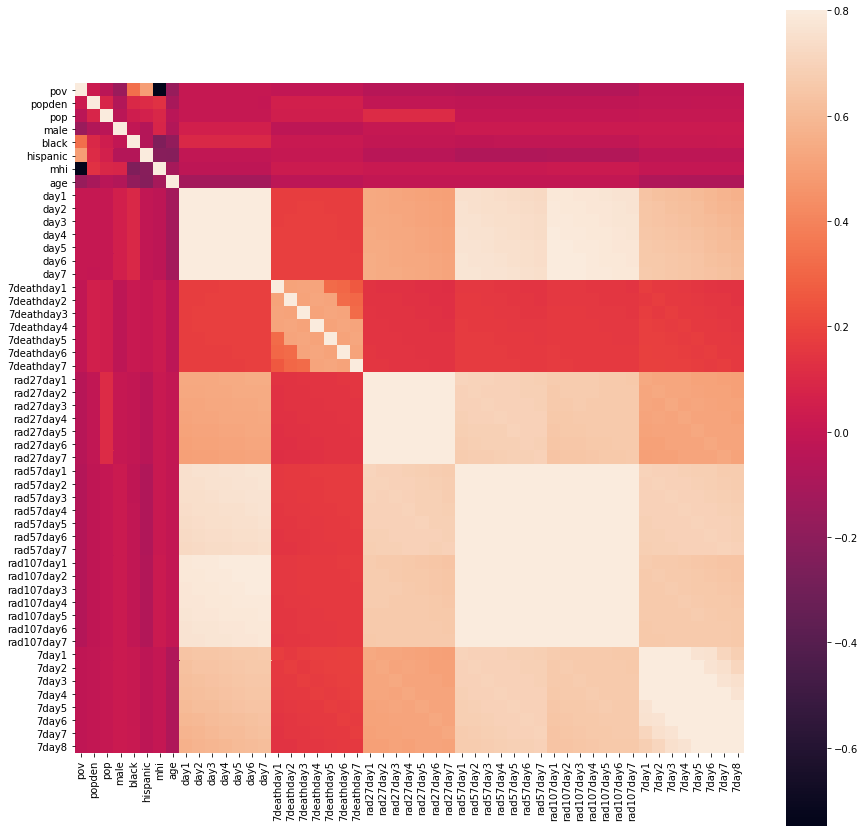

In [18]:
C_mat = cases_popcorrected.corr()
fig = plt.figure(figsize = (15,15))
sb.heatmap(C_mat, vmax = .8, square = True)
plt.show()

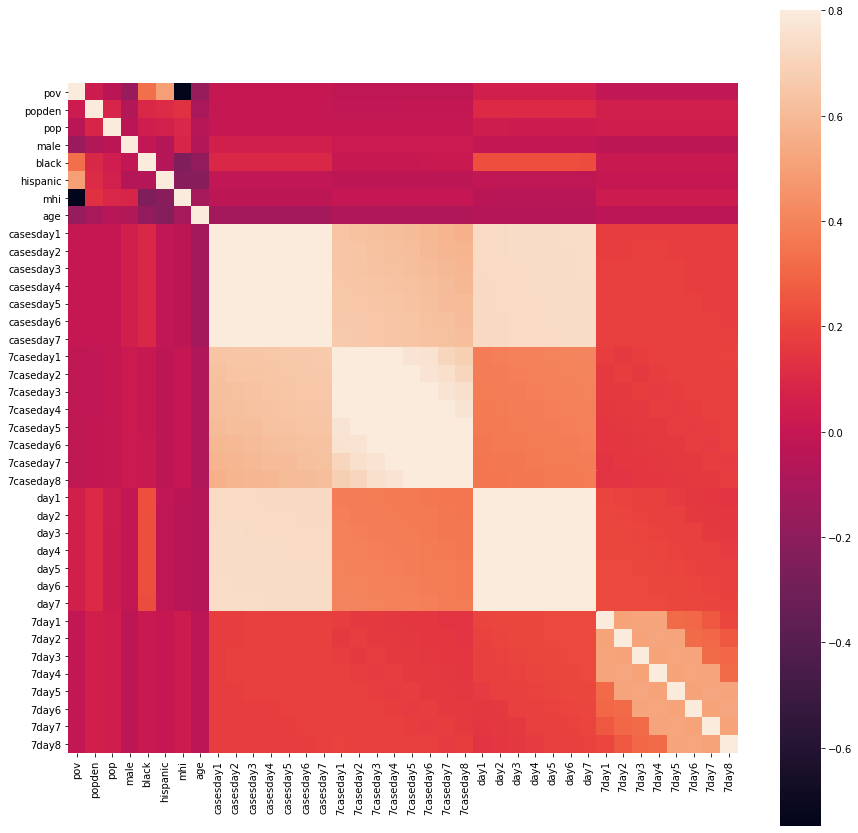

In [19]:
C_mat = deaths_popcorrected.corr()
fig = plt.figure(figsize = (15,15))
sb.heatmap(C_mat, vmax = .8, square = True)
plt.show()

In [20]:
x= cases_popcorrected[["popden","black","hispanic","age",'day7','rad57day7','7day7']]
y= cases_popcorrected['7day8'].values.reshape(-1, 1)
X = deaths_popcorrected[["popden","black","hispanic","mhi","age",'7caseday1','day7','7day7']]
Y = deaths_popcorrected['7day8'].values.reshape(-1, 1)
print(X.shape, Y.shape, x.shape,y.shape)

(1161560, 8) (1161560, 1) (1161560, 7) (1161560, 1)


In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42)
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

In [22]:
model = Sequential()
model.add(Dense(16, kernel_initializer='normal',activation='relu', input_dim=X_train.shape[1]))
# Add a second hidden layer
model.add(Dense(32, kernel_initializer='normal',activation='relu'))
model.add(Dense(32, kernel_initializer='normal',activation='relu'))
model.add(Dense(32, kernel_initializer='normal',activation='relu'))
model.add(Dense(32, kernel_initializer='normal',activation='relu'))
model.add(Dense(32, kernel_initializer='normal',activation='relu'))
model.add(Dense(32, kernel_initializer='normal',activation='relu'))
# Y_train = to_categorical(Y_train)
# Add output layer
model.add(Dense(1,activation='linear'))
model.compile(loss="huber_loss",optimizer="Adam", metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                144       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_6 (Dense)              (None, 32)                1

In [23]:
checkpoint_name = "models/Deaths--Weights-{epoch:03d}--{val_loss:.5f}--{val_accuracy:.5f}"

checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 0,
                                                save_best_only = True, mode ='auto')
# Use the training data to fit (train) the model
model.fit(X_train,Y_train,epochs=250,shuffle=True,verbose=0,validation_split = 0.2,callbacks=[checkpoint])

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models\Deaths--Weights-001--0.05865--0.91531\assets
INFO:tensorflow:Assets written to: models\Deaths--Weights-002--0.05744--0.91052\assets
INFO:tensorflow:Assets written to: models\Deaths--Weights-003--0.05627--0.90711\assets
INFO:tensorflow:Assets written to: models\Deaths--Weights-005--0.05620--0.91164\assets
INFO:tensorflow:Assets written to: models\Deaths--Weights-024--0.05292--0.90718\assets
INFO:tensorflow:Assets written to: models\Deaths--Weights-025--0.05153--0.90944\assets
INFO:tensorflow:Assets written to: models\Deaths--Weights-027--0.04847--0.90809\assets
INFO:tensorflow:Assets written to: models\Deaths--Weights-032--0.04781--0.90776\assets
INFO:tensorflow:Assets written to: models\Deaths--Weights-039--0.04693

In [24]:
model2 = Sequential()
model2.add(Dense(14, kernel_initializer='normal',activation='relu', input_dim=x_train.shape[1]))
# Add a second hidden layer
model2.add(Dense(28, kernel_initializer='normal',activation='relu'))
model2.add(Dense(28, kernel_initializer='normal',activation='relu'))
model2.add(Dense(28, kernel_initializer='normal',activation='relu'))
model2.add(Dense(28, kernel_initializer='normal',activation='relu'))
model2.add(Dense(28, kernel_initializer='normal',activation='relu'))
model2.add(Dense(28, kernel_initializer='normal',activation='relu'))
# Y_train = to_categorical(Y_train)
# Add output layer
model2.add(Dense(1,activation='linear'))
model2.compile(loss="huber_loss",optimizer="Adam", metrics=['accuracy'])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 14)                112       
_________________________________________________________________
dense_9 (Dense)              (None, 28)                420       
_________________________________________________________________
dense_10 (Dense)             (None, 28)                812       
_________________________________________________________________
dense_11 (Dense)             (None, 28)                812       
_________________________________________________________________
dense_12 (Dense)             (None, 28)                812       
_________________________________________________________________
dense_13 (Dense)             (None, 28)                812       
_________________________________________________________________
dense_14 (Dense)             (None, 28)               

In [25]:
checkpoint_name = "models/Cases--Weights-{epoch:03d}--{val_loss:.5f}--{val_accuracy:.5f}"

checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 0,
                                                save_best_only = True, mode ='auto')

# Use the training data to fit (train) the model
model2.fit(x_train,y_train,epochs=250,shuffle=True,verbose=0,validation_split = 0.2,callbacks=[checkpoint])

INFO:tensorflow:Assets written to: models\Cases--Weights-001--5.06312--0.38250\assets
INFO:tensorflow:Assets written to: models\Cases--Weights-005--5.00884--0.38003\assets
INFO:tensorflow:Assets written to: models\Cases--Weights-008--4.98953--0.38381\assets
INFO:tensorflow:Assets written to: models\Cases--Weights-011--4.98594--0.38465\assets
INFO:tensorflow:Assets written to: models\Cases--Weights-034--4.97565--0.37896\assets
INFO:tensorflow:Assets written to: models\Cases--Weights-058--4.97139--0.38187\assets
INFO:tensorflow:Assets written to: models\Cases--Weights-066--4.96505--0.38705\assets
INFO:tensorflow:Assets written to: models\Cases--Weights-133--4.96154--0.38624\assets
INFO:tensorflow:Assets written to: models\Cases--Weights-188--4.95881--0.38853\assets


In [26]:
X_train

,popden,black,hispanic,mhi,age,7caseday1,day7,7day7
972034,4.391765,0.064827,0.339941,46146.0,39.5,0.000000,0.000000,0.000000
989543,45.257332,0.103372,0.150365,46182.0,43.6,10.452160,0.000000,0.000000
638288,10.792910,0.016972,0.562138,43197.0,35.6,77.911364,183.320857,1.527674
972814,54.610805,0.124404,0.076799,43562.0,40.8,6.056691,18.170072,0.000000
1111770,18.584653,0.005309,0.017696,49982.0,52.5,39.323634,45.877572,0.000000
...,...,...,...,...,...,...,...,...
91808,6.287263,0.025647,0.095690,44644.0,58.4,0.000000,0.000000,0.000000
240718,16.164760,0.073330,0.004105,46151.0,45.8,0.000000,0.000000,0.000000
113472,11221.278689,0.469420,0.109242,82604.0,33.9,6.866346,90.431236,0.000000
652695,96.086751,0.044124,0.046406,63032.0,47.8,0.000000,60.736388,0.000000


In [27]:
x_train

,popden,black,hispanic,age,day7,rad57day7,7day7
972034,4.391765,0.064827,0.339941,39.5,0.000000,0.040835,0.000000
989543,45.257332,0.103372,0.150365,43.6,602.044443,28.664976,43.899074
638288,10.792910,0.016972,0.562138,35.6,12178.615622,47.265661,62.634626
972814,54.610805,0.124404,0.076799,40.8,270.532181,3.823752,4.037794
1111770,18.584653,0.005309,0.017696,52.5,2012.059248,56.006290,39.323634
...,...,...,...,...,...,...,...
91808,6.287263,0.025647,0.095690,58.4,366.379310,5.542905,0.000000
240718,16.164760,0.073330,0.004105,45.8,0.000000,0.000000,0.000000
113472,11221.278689,0.469420,0.109242,33.9,2160.707555,7.214808,7.158531
652695,96.086751,0.044124,0.046406,47.8,925.819531,4.073444,0.000000
